In [1]:
import numpy as np
from scipy.stats import percentileofscore
import matplotlib.pyplot as plt

from scipy.special import binom

import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()

%matplotlib inline

In [2]:
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [3]:
def lower_idx(S):
    return set(j for j in range(0, min(S))) | S

def higher_idx(S, n):
    return set(j for j in range(max(S), max(S))) | S

def neighbours(G, S):
    neigs = set()
    for node in S:
        neigs |= G['neig'][node]
    neigs -= S
    return neigs

def connected(G, S):
    T = {min(S)}
    while True:
        N = neighbours(G, T) & S
        if not N:
            break
        else:
            T |= N
    return T == S

def enumerate_csg(G):
    subsets = [{i} for i in range(G['n']-1, -1, -1)]
    for subset in subsets:
        yield subset
        yield from enumerate_csg_rec(G, subset, lower_idx(subset))

def enumerate_csg_rec(G, S, X):
    N = neighbours(G, S) - X
    subsets = [set(subset) for subset in powerset(N) if subset]
    for subset in subsets:
        yield S|subset
    for subset in subsets:
        yield from enumerate_csg_rec(G, S|subset, X|N)

def enumerate_cmp(G, S):
    X = lower_idx(S) | S
    N = neighbours(G, S) - X
    subsets = [{v} for v in sorted(N, reverse=True)]
    for subset in subsets:
        yield subset
        yield from enumerate_csg_rec(G, subset, X|(lower_idx(subset)&N))


In [4]:
def gen_graph_star(n):
    G = {'n': n, 'neig': []}
    for i in range(n):
        if i == 0:
            G['neig'].append({j for j in range(1,n)})
        else:
            G['neig'].append({0,})
    return G

def gen_graph_chain(n):
    G = {'n': n, 'neig': []}
    for i in range(n):
        if i == 0:
            G['neig'].append({1})
        elif i == n-1:
            G['neig'].append({n-2})
        else:
            G['neig'].append({i-1,i+1})
    return G

def gen_graph_clique(n):
    G = {'n': n, 'neig': []}
    for i in range(n):
        G['neig'].append(set(j for j in range(n) if j != i))
    return G

In [5]:
def get_sizes_freqs(G, eq_class, max_jobs):
    depbuf = np.zeros(G['n']+1)
    count = 0
    sizes = []
    for S in enumerate_csg(G):
        for Sc in enumerate_cmp(G, S):
            depbuf[eq_class(S,Sc)] += 1
            count += 1 
            if count >= max_jobs:
                sizes += [i for i in depbuf if i != 0]
                depbuf = np.zeros(G['n']+1)
                count = 0

    sizes += [i for i in depbuf if i != 0]
    return sizes

def srqs(S1, S2):
    return len(S1)+len(S2)

def slqs(S1, S2):
    return max(len(S1),len(S2))

In [6]:
def calculate_parallelism(G, eq_class, max_jobs, n_parallel):
    sizes = get_sizes_freqs(G, eq_class, max_jobs)
    n_iters = sum((s+n_parallel-1)//n_parallel for s in sizes)
    return sum(sizes)/n_iters

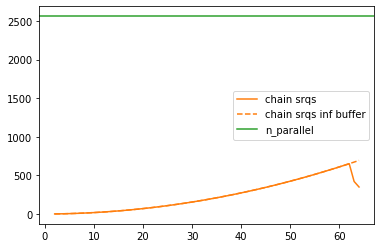

In [51]:
n_parallel = 2560
max_jobs = n_parallel*16
x = list(range(2,65))

# y_star = Parallel(n_jobs=num_cores)(delayed(calculate_parallelism)(gen_graph_star(i), srqs, max_jobs, n_parallel) for i in x)
y_chain = Parallel(n_jobs=num_cores)(delayed(calculate_parallelism)(gen_graph_chain(i), srqs, max_jobs, n_parallel) for i in x)
# plt.plot(x, y_star, label="star srqs", color="C0", linestyle="-")
plt.plot(x, y_chain, label="chain srqs", color="C1", linestyle="-")

y_chain_inf = Parallel(n_jobs=num_cores)(delayed(calculate_parallelism)(gen_graph_chain(i), srqs, np.inf, n_parallel) for i in x)
plt.plot(x, y_chain_inf, label="chain srqs inf buffer", color="C1", linestyle="--")

# y_star = Parallel(n_jobs=num_cores)(delayed(calculate_parallelism)(gen_graph_star(i), slqs, max_jobs, n_parallel) for i in x)
# y_chain = Parallel(n_jobs=num_cores)(delayed(calculate_parallelism)(gen_graph_chain(i), slqs, max_jobs, n_parallel) for i in x)
# plt.plot(x, y_star, label="star slqs", color="C0", linestyle="--")
# plt.plot(x, y_chain, label="chain slqs", color="C1", linestyle="--")

plt.axhline(n_parallel, label="n_parallel", color="C2")
plt.legend()

In [7]:
def enumerate_sub_csg(G, T, I, E):
    if I:
        subsets = [{min(I)}]
    else:
        subsets = [{i} for i in T-E]
    for subset in subsets:
        if subset >= I:
            yield subset
        yield from enumerate_sub_csg_rec(G, subset, lower_idx(subset), T, I-subset, E)

def enumerate_sub_csg_rec(G, S, X, T, I, E):
    N = (neighbours(G, S) - X) & (T-E)

    if I and min(I) in N:
        N = {min(I)}

    subsets = [set(subset) for subset in powerset(N) if subset]
    for subset in subsets:
        if subset >= I:
            yield S|subset
        yield from enumerate_sub_csg_rec(G, S|subset, X|N, T, I-subset, E)

In [8]:
def enumerate_sub_csg_stack(G, T, I, E):
    max_stack = 0
    stack = []
    if I:
        stack += [({min(I)}, lower_idx({min(I)}))]
    else:
        stack += [({i}, lower_idx({i})) for i in T-E]

    while stack:
        max_stack = max(max_stack, len(stack))
        S, X = stack.pop()
        if I <= S:
            yield S
        
        N = (neighbours(G, S) - X) & (T-E)

        if (I-S) and min(I-S) in N:
            N = {min(I-S)}

        stack += [(S|set(subset), X|N) for subset in powerset(N) if subset]

    return max_stack

def next_subset(subset, N):
    subsets = list(set(subset) for subset in powerset(N))
    try:
        return set(subsets[subsets.index(subset)+1])
    except:
        return set()


def enumerate_sub_csg_short_stack(G, T, I, E):
    max_stack = 0
    stack = []
    
    if I:
        stack += [({min(I)}, set(), lower_idx({min(I)}), set())]
    else:
        stack += [({i}, set(), lower_idx({i}), set()) for i in T-E]

    while stack:
        max_stack = max(max_stack, len(stack))

        S, subset, X, N = stack.pop()
        
        if not subset and I <= S:
            yield S

        if not N:
            N = (neighbours(G, S) - X) & (T-E)

            if (I-S) and min(I-S) in N:
                N = {min(I-S)}

        subset = next_subset(subset, N)
        if subset:
            stack.append((S, subset, X, N))
            stack.append((S|subset, set(), X|N, set()))

    return max_stack

def enumerate_sub_csg_short_multi_stack(G, T, I, E):
    max_stack = 0
    emit_stack = []
    loop_stack = []
    if I:
        emit_stack += [({min(I)}, lower_idx({min(I)}))]
    else:
        emit_stack += [({i}, lower_idx({i})) for i in T-E]

    while emit_stack or loop_stack:
        max_stack = max(max_stack, len(emit_stack), len(loop_stack))

        if emit_stack:
            S, X = emit_stack.pop()
        
            if I <= S:
                yield S

            N = (neighbours(G, S) - X) & (T-E)

            if (I-S) and min(I-S) in N:
                N = {min(I-S)}

            loop_stack.append((S, set(), X, N))

        if loop_stack:
            S, subset, X, N = loop_stack.pop()
            subset = next_subset(subset, N)

            if subset:
                loop_stack.append((S, subset, X, N))
                emit_stack.append((S|subset, X|N))

    return max_stack

def enumerate_sub_csg_short_stack_unrolled(G, T, I, E):
    max_stack = 0
    loop_stack = []

    if I:
        loop_stack += [(set(), lower_idx({min(I)}), {min(I)})]
    else:
        loop_stack += [(set(), lower_idx({i}), {i}) for i in T-E]

    while loop_stack:
        max_stack = max(max_stack, len(loop_stack))

        S, X, N = loop_stack.pop()
        subset = next_subset(S&N, N)
        emit_S = (S-N)|subset
        
        if subset and I <= emit_S:
            yield emit_S

        if subset:
            loop_stack.append((emit_S, X, N))

            emit_X = X|N
            N = (neighbours(G, emit_S) - emit_X) & (T-E)

            if (I-emit_S) and min(I-emit_S) in N:
                N = {min(I-emit_S)}

            if N:
                loop_stack.append((emit_S, emit_X, N))

    return max_stack

In [9]:
class Generator:
    def __init__(self, gen):
        self.gen = gen

    def __iter__(self):
        self.value = yield from self.gen

def collect_all_subs(G, T, I):
    E = R-I
    l = []
    gen = Generator(enumerate_sub_csg_short_stack_unrolled(G, T, I, E))
    for S in gen:
        l.append(tuple(sorted(S)))
    return l, gen.value

In [103]:
N = 12
G = gen_graph_star(N)
# G = {
#     'n': 5,
#     'neig': [
#         {2},
#         {3},
#         {0,3,4},
#         {1,2,4},
#         {2,3}
#     ]
# }
# T = {0,1,2}
# R = {0}
# K = len(T)

K = 12
T = set(range(K))
R = {0,1}

max_stack = 0
n_subs = 0
Is = [set(subset) for subset in powerset(R)]

collect_all_subs(G, T, set())
                                                                                                                                                            
parallel_ret = Parallel(n_jobs=num_cores)(delayed(collect_all_subs)(G, T, I) for I in Is)
all_subs = [subs for subs, max_stack in parallel_ret]

print("max_stack:", max(max_stack for subs, max_stack in parallel_ret))

all_subs_set = set()
n_gen_subs = 0
for l in all_subs:
    for t in l:
        if t in all_subs_set:
            print("Warning: duplicate tuple", t)
        all_subs_set.add(t)
        n_gen_subs += 1

all_valid_subs = {tuple(sorted(S)) for S in enumerate_sub_csg(G, T, set(), set())}

if not (all_subs_set >= all_valid_subs):
    missing = all_valid_subs-all_subs_set
    if len(missing) < 10:
        print("Error: missing", len(missing), "subsets", missing)
    else:
        print("Error: missing", len(missing), "subsets")

print("n_sets:", int(binom(N,K)))
print("n_unique_subs:", len(all_subs_set))
print("n_gen_subs:", n_gen_subs)
print("n_valid_subs:", len(all_valid_subs))
print("n_all_subs:", 2**len(T)-2)

max_stack: 10
n_sets: 1
n_unique_subs: 2059
n_gen_subs: 2059
n_valid_subs: 2059
n_all_subs: 4094


In [22]:
def get_n_pairs(G):
    from scipy.special import binom

    n_gen_pairs = 0
    n_gen_conn_pairs = 0
    for subset in powerset(set(range(G['n']))):
        T = set(subset)
        if len(subset) >= 2:
            all_valid_subs = {tuple(sorted(S)) for S in enumerate_sub_csg(G, T, set(), set())}
            n_gen_pairs += len(all_valid_subs)
            if connected(G, T):
                n_gen_conn_pairs += len(all_valid_subs)

    subsets = set()
    sizes = [0] * G['n']
    sizes[0] = G['n']
    n_valid_pairs = 0
    for S in enumerate_csg(G):
        for Sc in enumerate_cmp(G, S):
            key = tuple(S|Sc)
            if key not in subsets:
                sizes[len(S|Sc)-1] += 1
                subsets.add(key)
            n_valid_pairs += 1

    n_dpsize_pairs = 0
    for s in range(2,G['n']+1):
        for i in range(1, s):
            n_dpsize_pairs += sizes[i-1] * sizes[s-i-1]

    n_dpsub_pairs = 0
    for i in range(2,G['n']+1):
        n_dpsub_pairs += int(binom(G['n'],i)) * (2**i-2)

    n_dpsub_conn_pairs = 0
    for i in range(2,G['n']+1):
        n_dpsub_conn_pairs += sizes[i-1] * (2**i-2)

    return n_valid_pairs, n_dpsize_pairs, n_dpsub_pairs, n_dpsub_conn_pairs, n_gen_pairs, n_gen_conn_pairs

def pairs_to_size(n_pairs):
    unit = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
    unit_idx = 0
    n_bytes = n_pairs * 16
    while n_bytes > 1024:
        n_bytes /= 1024
        unit_idx += 1
    return f"{n_bytes:.2f}{unit[unit_idx]}"

In [12]:
N = 10
G = gen_graph_star(N)
n_valid_pairs, n_dpsize_pairs, n_dpsub_pairs, n_dpsub_conn_pairs, n_gen_pairs, n_gen_conn_pairs = get_n_pairs(G)
print("n_valid_pairs:", n_valid_pairs, pairs_to_size(n_valid_pairs))
print("n_dpsize_pairs:", n_dpsize_pairs, pairs_to_size(n_dpsize_pairs))
print("n_dpsub_pairs:", n_dpsub_pairs, pairs_to_size(n_dpsub_pairs))
print("n_dpsub_conn_pairs:", n_dpsub_conn_pairs, pairs_to_size(n_dpsub_conn_pairs))
print("n_gen_pairs:", n_gen_pairs, pairs_to_size(n_gen_pairs))
print("n_gen_conn_pairs:", n_gen_conn_pairs, pairs_to_size(n_gen_conn_pairs))

n_valid_pairs: 2304 36.00KB
n_dpsize_pairs: 137553 2.10MB
n_dpsub_pairs: 57002 890.66KB
n_dpsub_conn_pairs: 38682 604.41KB
n_gen_pairs: 24281 379.39KB
n_gen_conn_pairs: 21986 343.53KB


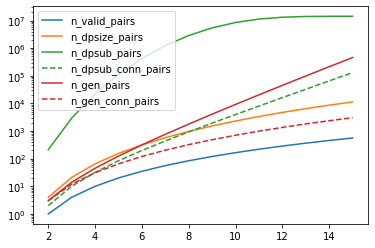

In [38]:
N = 15
parallel_ret = Parallel(n_jobs=num_cores)(delayed(get_n_pairs)(gen_graph_chain(n)) for n in range(2,N+1))
series = [[] for i in range(6)]
series_color = ['C0', 'C1', 'C2', 'C2', 'C3', 'C3']
series_linestyle = ['-', '-', '-', '--', '-', '--']
series_label = ["n_valid_pairs", "n_dpsize_pairs", "n_dpsub_pairs", "n_dpsub_conn_pairs", "n_gen_pairs", "n_gen_conn_pairs"]

for r in parallel_ret:
    for i, n in enumerate(r):
        series[i].append(n)

x = list(range(2,N+1))
for i in range(len(series)):
    plt.plot(x, series[i], color=series_color[i], linestyle=series_linestyle[i], label=series_label[i])

plt.yscale('log')
plt.legend()
plt.show()


In [18]:
pairs_to_size(4980736)

'76.00MB'

In [30]:
# Musicbrainz

G_musicbrainz = {
    'n': 56,
    'neig': [
        {1,2}, #  0
        {0}, #  1
        {0,3,4,5,6,7,8}, #  2
        {2}, #  3
        {2}, #  4
        {2}, #  5
        {2}, #  6
        {2,9,10,11,12,13,14,15,16}, #  7
        {2,17}, #  8
        {7,22}, #  9
        {7,23,24}, # 10
        {7}, # 11
        {7}, # 12
        {7}, # 13
        {7,25,26,27,28,29}, # 14
        {7}, # 15
        {7,30}, # 16
        {8,18,19,20,21}, # 17
        {17,31,32,19}, # 18
        {17,18,30,29,37,38,40,41,42,34}, # 19
        {17,21,34}, # 20
        {17,20,33}, # 21
        {9}, # 22
        {10}, # 23
        {10,35}, # 24
        {14}, # 25
        {14,36}, # 26
        {14}, # 27
        {14}, # 28
        {14,19}, # 29
        {16,19}, # 30
        {18,55}, # 31
        {18}, # 32
        {21}, # 33
        {20,43,19,44}, # 34
        {24}, # 35
        {26}, # 36
        {19}, # 37
        {19,56}, # 38
        set(), # 39
        {19}, # 40
        {19}, # 41
        {19}, # 42
        {34}, # 43
        {34,46}, # 44
        {56,47,48,49,50}, # 45
        {44}, # 46
        {45,51}, # 47
        {45}, # 48
        {45}, # 49
        {45,52,53}, # 50
        {47}, # 51
        {50,53}, # 52
        {50,52}, # 53
        set(), # 54
        {31}, # 55
        {38,45}, # 56
    ],
    'labels': [
        "artist_alias", #  0
        "artist_alias_type", #  1
        "artist", #  2
        "artist_type", #  3
        "artist_ipi", #  4
        "gender", #  5
        "artist_isni", #  6
        "area", #  7
        "artist_credit_name", #  8
        "area_alias", #  9
        "place", # 10
        "iso_3166_1", # 11
        "iso_3166_2", # 12
        "iso_3166_3", # 13
        "label", # 14
        "area_type", # 15
        "country_area", # 16
        "artist_credit", # 17
        "release_group", # 18
        "release", # 19
        "track", # 20
        "recording", # 21
        "area_alias_type", # 22
        "place_type", # 23
        "place_alias", # 24
        "label_type", # 25
        "label_alias", # 26
        "label_isni", # 27
        "label_ipi", # 28
        "release_label", # 29
        "release_country", # 30
        "release_group_secondary_type_join", # 31
        "release_group_primary_type", # 32
        "isrc", # 33
        "medium", # 34
        "place_alias_type", # 35
        "label_alias_type", # 36
        "release_unknown_country", # 37
        "language", # 38
        "script_language", # 39 - no longer exists
        "script", # 40
        "release_packaging", # 41
        "release_status", # 42
        "medium_format", # 43
        "medium_cdtoc", # 44
        "work", # 45
        "cdtoc", # 46
        "work_alias", # 47
        "work_type", # 48
        "iswc", # 49
        "work_attribute", # 50
        "work_alias_type", # 51
        "work_attribute_type_allowed_value", # 52
        "work_attribute_type", # 53
        "url", # 54
        "release_group_secondary_type", # 55
        "work_language" # 56
    ],
    'edge_attributes': [
        {1:('type','id'),2:('artist','id')}, #  0
        {0:('id','type')}, #  1
        {0:('id','artist'),3:('type','id'),4:('id','artist'),5:('gender','id'),6:('id','artist'),7:('area','id'),8:('id','artist')}, #  2
        {2:('id','type')}, #  3
        {2:('artist','id')}, #  4
        {2:('id','gender')}, #  5
        {2:('artist','id')}, #  6
        {2:('id','area'),9:('id','area'),10:('id','area'),11:('id','area'),12:('id','area'),13:('id','area'),14:('id','area'),15:('type','id'),16:('id','area')}, #  7
        {2:('artist','id'),17:('artist_credit','id')}, #  8
        {7:('area','id'),22:('type','id')}, #  9
        {7:('area','id'),23:('type','id'),24:('id','place')}, # 10
        {7:('area','id')}, # 11
        {7:('area','id')}, # 12
        {7:('area','id')}, # 13
        {7:('area','id'),25:('type','id'),26:('id','label'),27:('id','label'),28:('id','label'),29:('id','label')}, # 14
        {7:('id','type')}, # 15
        {7:('area','id'),30:('area','country')}, # 16
        {8:('id','artist_credit'),18:('id','artist_credit'),19:('id','artist_credit'),20:('id','artist_credit'),21:('id','artist_credit')}, # 17
        {17:('artist_credit','id'),31:('id','release_group'),32:('type','id'),19:('id','release_group')}, # 18
        {17:('artist_credit','id'),18:('release_group','id'),30:('id','release'),29:('id','release'),37:('id','release'),38:('language','id'),40:('script','id'),41:('packaging','id'),42:('status','id'),34:('id','release')}, # 19
        {17:('artist_credit','id'),21:('recording','id'),34:('medium','id')}, # 20
        {17:('artist_credit','id'),20:('id','recording'),33:('id','recording')}, # 21
        {9:('id','type')}, # 22
        {10:('id','type')}, # 23
        {10:('place','id'),35:('type','id')}, # 24
        {14:('id','type')}, # 25
        {14:('label','id'),36:('type','id')}, # 26
        {14:('label','id')}, # 27
        {14:('label','id')}, # 28
        {14:('label','id'),19:('release','id')}, # 29
        {16:('country','area'),19:('release','id')}, # 30
        {18:('release_group','id'),55:('secondary_type','id')}, # 31
        {18:('id','type')}, # 32
        {21:('recording','id')}, # 33
        {20:('id','medium'),43:('format','id'),19:('release','id'),44:('id','medium')}, # 34
        {24:('id','type')}, # 35
        {26:('id','type')}, # 36
        {19:('release','id')}, # 37
        {19:('id','language'),56:('id','language')}, # 38
        {}, # 39
        {19:('id','script')}, # 40
        {19:('id','packaging')}, # 41
        {19:('id','status')}, # 42
        {34:('id','format')}, # 43
        {34:('medium','id'),46:('cdtoc','id')}, # 44
        {56:('id','work'),47:('id','work'),48:('type','id'),49:('id','work'),50:('id','work')}, # 45
        {44:('id','cdtoc')}, # 46
        {45:('work','id'),51:('type','id')}, # 47
        {45:('id','type')}, # 48
        {45:('work','id')}, # 49
        {45:('work','id'),52:('work_attribute_type_allowed_value','id'),53:('work_attribute_type','id')}, # 50
        {47:('id','type')}, # 51
        {50:('id','work_attribute_type_allowed_value'),53:('work_attribute_type','id')}, # 52
        {50:('id','work_attribute_type'),52:('id','work_attribute_type')}, # 53
        {}, # 54
        {31:('id','secondary_type')}, # 55
        {45:('work','id'),38:('language','id')}, # 56
    ]
}

# check bidirectionality
for i,neig in enumerate(G_musicbrainz['neig']):
    for j in neig:
        try:
            assert(i in G_musicbrainz['neig'][j])
            assert(G_musicbrainz['edge_attributes'][i][j][0] == G_musicbrainz['edge_attributes'][j][i][1])
            assert(G_musicbrainz['edge_attributes'][i][j][1] == G_musicbrainz['edge_attributes'][j][i][0])
        except:
            print(i,j)
            raise
print("OK")


OK


In [18]:
from random import choice, randint, shuffle

def gen_random_query(G, N):
    neigs = set(range(G['n']))
    queryset = set()
    from_clauses = []
    where_clauses = []

    G_out = {'n': N, 'neig': [set() for i in range(N)]}
    remapping = {}

    n = 0
    while len(queryset) < N:
        if not neigs:
            break

        node = choice(tuple(neigs))
        remapping[node] = n

        if queryset:
            peers = [n for n in queryset if n in G['neig'][node]]
            shuffle(peers)
            for i in range(randint(1,len(peers))):
                peer = peers[i]
                edge = G['edge_attributes'][peer][node]
                where_clauses.append(f"\"{G['labels'][peer]}\".\"{edge[0]}\" = \"{G['labels'][node]}\".\"{edge[1]}\"")
                G_out['neig'][remapping[node]].add(remapping[peer])
                G_out['neig'][remapping[peer]].add(remapping[node])

        queryset.add(node)
        from_clauses.append(G['labels'][node])
        neigs = neighbours(G, queryset)

        n += 1
    
    if len(queryset) < N:
        # print(f"No more neighbors at size {len(queryset)}, retrying")
        return gen_random_query(G, N)
    else:
        from_clause = '", "'.join(from_clauses)
        where_clause = ' AND '.join(where_clauses)
        return G_out, f"SELECT * FROM \"{from_clause}\" WHERE {where_clause};"

In [23]:
G, query = gen_random_query(G_musicbrainz, 10)
print(query)
print(G)
n_valid_pairs, n_dpsize_pairs, n_dpsub_pairs, n_dpsub_conn_pairs, n_gen_pairs, n_gen_conn_pairs = get_n_pairs(G)
print("n_valid_pairs:", n_valid_pairs, pairs_to_size(n_valid_pairs))
print("n_dpsize_pairs:", n_dpsize_pairs, pairs_to_size(n_dpsize_pairs))
print("n_dpsub_pairs:", n_dpsub_pairs, pairs_to_size(n_dpsub_pairs))
print("n_dpsub_conn_pairs:", n_dpsub_conn_pairs, pairs_to_size(n_dpsub_conn_pairs))
print("n_gen_pairs:", n_gen_pairs, pairs_to_size(n_gen_pairs))
print("n_gen_conn_pairs:", n_gen_conn_pairs, pairs_to_size(n_gen_conn_pairs))

SELECT * FROM "cdtoc", "medium_cdtoc", "medium", "track", "recording", "artist_credit", "release", "script", "release_label", "release_country" WHERE "cdtoc"."id" = "medium_cdtoc"."cdtoc" AND "medium_cdtoc"."medium" = "medium"."id" AND "medium"."id" = "track"."medium" AND "track"."id" = "recording"."recording" AND "track"."artist_credit" = "artist_credit"."id" AND "medium"."release" = "release"."id" AND "release"."script" = "script"."id" AND "release"."id" = "release_label"."release" AND "release"."id" = "release_country"."release";
{'n': 10, 'neig': [{1}, {0, 2}, {1, 3, 6}, {2, 4, 5}, {3}, {3}, {8, 9, 2, 7}, {6}, {6}, {6}]}
n_valid_pairs: 668 10.44KB
n_dpsize_pairs: 11381 177.83KB
n_dpsub_pairs: 57002 890.66KB
n_dpsub_conn_pairs: 14424 225.38KB
n_gen_pairs: 11827 184.80KB
n_gen_conn_pairs: 4192 65.50KB


In [82]:
def get_gen_valid_ratio(n):
    G, query = gen_random_query(G_musicbrainz, n)
    n_valid_pairs, n_dpsize_pairs, n_dpsub_pairs, n_dpsub_conn_pairs, n_gen_pairs, n_gen_conn_pairs = get_n_pairs(G)
    return n, n_gen_conn_pairs/n_valid_pairs

N = 20
R = 3

results = Parallel(n_jobs=num_cores)(delayed(get_gen_valid_ratio)(n) for n in range(2,N+1) for i in range(R))

x = [r[0] for r in results]
y = [r[1] for r in results]

plt.scatter(x, y)

KeyboardInterrupt: 

In [31]:
import string
labels = [f"{a}{b}" for a in string.ascii_lowercase for b in string.ascii_lowercase]
for n in range(2,33):
    for i in range(15):
        G, query = gen_random_query(G_musicbrainz, n)
        with open(f"musicbrainz/queries/{n:02d}{labels[i]}.sql", 'w') as f:
            f.write(query)
            f.write("\n")